In [1]:
# OPF-driven MPC
    # For Resiliency Improvement in (Islanded) Distribution Systems
    # Objective:
        # maximize the total /priority-weighted/ load (active and reactive) served
        # penalize restored load shedding
        # penalize wind and pv power curtailment
# The distribution grid model is written in Julia
# The MPC is written in Julia 
# The data analytics (pre/post-processing) and forecasts are written in Python
# The MPC calling is written in Python (this notebook)
# Three-phase balanced distribution system
# With Reserve

In [2]:
# Import required Python packages/modules

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
#sbn.set()
from datetime import datetime
import os

In [3]:
# Calling Julia Packages from Python
# Install Julia packages required by PyJulia

import julia
from julia.api import Julia
jl = Julia(compiled_modules=False)  
jl = julia.Julia()

In [4]:
# Include the Julia codes
    # Data preprocessing code
    # MPC code
    
jl.include("data_handler_threephase.jl");
jl.include("lr_reserve_threephase_opf_mpc.jl");

/Users/aeseye/.local/lib/python3.7/site-packages/julia/core.py:689: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


In [5]:
# Get the current directory

cur_dir = os.getcwd()

# Default/base network data (if any)

DATA_DIR = "basecase"

In [6]:
# Parameters

Δt = 5/60
SOC0 = 90

# Base values

Zbase = 1
Vbase = 4160
Sbase = (Vbase**2)/Zbase
Cbase = 800

In [7]:
# Get the the distribution grid information to the MPC

BUSES, LINES, GENERATORS, WINDTURBINES, PVS, STORAGES = jl.load_case_data(datafile="13buscase")

In [8]:
# Exogenous data - wind and pv profiles - forecasts

# Forecast (Wind & PV) Reader 

# Change the current path to the exogenous data path
exo_data_path = os.chdir(os.path.dirname(cur_dir)+'/dataset/exogenous_data')

class ForecastReader:
    def __init__(self, forecast_pointers_file='forecast_pointers.csv'):
        self._forecast_pointers = pd.read_csv(forecast_pointers_file, parse_dates=['Time'],
                                        index_col=0, infer_datetime_format=True).to_dict()['forecast_file']

    def get_forecast(self, datetime):
        '''
        Get the forecast as a pandas dataframe for the datetime
        '''
        k = pd.Timestamp(datetime)

        if k not in self._forecast_pointers:
            raise Exception(f"Datetime {datetime} does not have a forecast available")

        return pd.read_csv(self._forecast_pointers[k], parse_dates=['Time'], index_col=0, infer_datetime_format=True)

    def available_dates(self):
        return self._forecast_pointers.keys()

# Get the dates of interest (dates in the control horizon)

# Specify the starting point for the forecasts
    # 2019-08-03 12:00 for paper results 31*24*12 + 2*24*12 + 144
Start_index = 31*24*12 + 2*24*12 + 144         # 2019-08-03 12:0
#Start_index = 31*24*12 + 1*24*12 + 0      # 2019-08-02 00:00 
#Start_index = 31*24*12 + 3*24*12 + 144-24    # 2019-08-04 10:00 

# Define the optimization horizon (6 hours == 72 5-minutes)
num_time_steps = 72
dates_object = ForecastReader()
dates = dates_object.available_dates()
dateslist = list()
for time in dates:
    dateslist.append(time)
datetimes_6h = dateslist[Start_index:Start_index+num_time_steps]

# Get the PV and Wind forecasts
# and put together all the forecasts in all the time steps in the control horizon

# Define the rated capacities (kW) of the renewable generators
wind_mult = 150
pv_mult = 300

num_time_steps_in_a_day = 288
Pwind_forecast_all = np.empty((0, num_time_steps_in_a_day))
Psolar_forecast_all = np.empty((0, num_time_steps_in_a_day))

for datetime in datetimes_6h:
    # Read the Wind and PV Power Forecasts
    forecast_object = ForecastReader()
    forecast = forecast_object.get_forecast(datetime)
    Pwind = wind_mult*np.array(forecast['wind_gen'])
    Pwind_forecast_all = np.append(Pwind_forecast_all, [Pwind], axis=0)
    Psolar = pv_mult*np.array(forecast['pv_gen'])
    Psolar_forecast_all = np.append(Psolar_forecast_all, [Psolar], axis=0)

In [9]:
#datetimes_6h

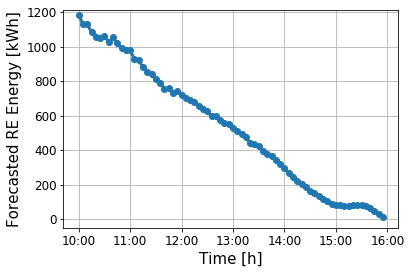

forecasted_re_energy_kWh:  38438.874819698176


In [10]:
# Plot the RE energy forecast at each step

T = range(num_time_steps)
forecasted_wind_energy = 0 
forecasted_solar_energy = 0 
forecasted_tot_wind_energy = ([])
forecasted_tot_solar_energy = ([])
for idx in T:

    # Update the wind at each step
    
    wind = Pwind_forecast_all[idx, 0:72-idx]
    pv = Psolar_forecast_all[idx, 0:72-idx]
    
    forecasted_tot_wind_energy = np.append(forecasted_tot_wind_energy, sum(wind)*Δt)
    forecasted_tot_solar_energy = np.append(forecasted_tot_solar_energy, sum(pv)*Δt)
    
    forecasted_wind_energy = forecasted_wind_energy + sum(wind)*Δt
    forecasted_solar_energy = forecasted_solar_energy + sum(pv)*Δt

forecasted_tot_re_energy = forecasted_tot_wind_energy + forecasted_tot_solar_energy
forecasted_re_energy = forecasted_wind_energy + forecasted_solar_energy

plt.plot(forecasted_tot_re_energy,marker='o', linewidth = 3)
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Forecasted RE Energy [kWh]', fontsize=15)
plt.ylim((-50, 1210))
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(10*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()

print("forecasted_re_energy_kWh: ", forecasted_re_energy)

In [11]:
# Exogenous data - wind and pv profiles - actuals

exo_data_path = os.path.dirname(cur_dir)+"/dataset/exogenous_data/five_min_renewable_profile.csv"
exo_data = pd.read_csv(exo_data_path, index_col=0)

start_idx = 0
duration = num_time_steps_in_a_day

wind_profile = exo_data["wind_gen"][start_idx:start_idx+duration]
pv_profile = exo_data["pv_gen"][start_idx:start_idx+duration]

wind_mult = 150
pv_mult = 300

wind = wind_mult * wind_profile
pv = pv_mult * pv_profile

Pwt = 1000 * wind /Sbase
Ppv = 1000 * pv /Sbase


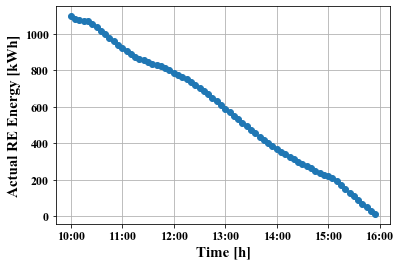

actual_re_energy_kWh:  41923.471314949995


In [12]:
# Plot the RE energy actual at each step

#starttime = "2019-08-04 10:00:00"   # Under-forecasted case
#stoptime = "2019-08-04 16:00:00"

starttime = "2019-08-03 12:00:00"
stoptime = "2019-08-03 18:00:00"

#starttime = "2019-08-02 00:00:00"  # Over-forecasted case
#stoptime = "2019-08-02 06:00:00"

actual_wind_energy = 0 
actual_solar_energy = 0 

# Plot the RE energy actual at each step

wind1 = wind_mult*pd.DataFrame(exo_data[starttime:stoptime])['wind_gen']
pv1 = pv_mult*pd.DataFrame(exo_data[starttime:stoptime])['pv_gen']

T = range(num_time_steps)
actual_tot_wind_energy = ([])
actual_tot_solar_energy = ([])
for idx in T:

    # Update the wind at each step
    
    wind_act = wind1[idx:72]
    pv_act = pv1[idx:72]
    
    actual_tot_wind_energy = np.append(actual_tot_wind_energy, sum(wind_act)*Δt)
    actual_tot_solar_energy = np.append(actual_tot_solar_energy, sum(pv_act)*Δt)
    
    actual_wind_energy = actual_wind_energy + sum(wind_act)*Δt
    actual_solar_energy = actual_solar_energy + sum(pv_act)*Δt
    
actual_tot_re_energy = actual_tot_wind_energy + actual_tot_solar_energy
actual_re_energy = actual_wind_energy + actual_solar_energy
plt.plot(actual_tot_re_energy, marker='o')
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Actual RE Energy [kWh]', fontsize=15)
#plt.ylim((-50, 1800))
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(10*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()
print("actual_re_energy_kWh: ", actual_re_energy)


In [13]:
# Over-forecasted or under-forecasted?

forecast_energy_error = actual_re_energy - forecasted_re_energy
print("forecast_energy_error_kWh: ", forecast_energy_error)

forecast_energy_error_kWh:  3484.596495251819


In [14]:
# Load demand time series in per unit (pu)

d_P = np.zeros((len(BUSES), num_time_steps_in_a_day))
d_Q = np.zeros((len(BUSES), num_time_steps_in_a_day))
for b in jl.keys(BUSES):
    for t in range(num_time_steps_in_a_day):
        if b == 2:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 3:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q 
        if b == 5:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 6:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 7:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 9:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 10:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 11:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 12:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q

Pd = d_P       # active_power_demand
Qd = d_Q;      # reactive_power_demand

# Total active power demand at each time step

P_d_tot = np.zeros((num_time_steps_in_a_day))
for jdx in range(num_time_steps_in_a_day):
    P_d_tot[jdx] = np.sum(Pd[:,jdx]) 


Q_d_tot = np.zeros((num_time_steps_in_a_day))
for jdx in range(num_time_steps_in_a_day):
    Q_d_tot[jdx] = np.sum(Qd[:,jdx]) 

# Number of buses

num_buses = len(BUSES)

# Number of load buses

load_buses = jl.findall(Pd[:,0] != 0.0)
num_load_buses = len(load_buses)


In [15]:
# Plot - Load vs Renewables -- !Change this plot with actuals vs forecasts for all time steps in the control horizon

In [16]:
# Inputs to MPC

es_soc = 90
mt_energy = 1000
active_power_demanded = Pd
reactive_power_demanded = Qd
active_power_restored = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
reactive_power_restored = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

num_buses = len(BUSES)
num_lines = len(LINES)

# // Set array to store the MPC results

Pmtt = ([])
Qmtt = ([])
Pess = ([])
Qess = ([])
SOCes = ([])
Pwt_cutt = ([])
Ppv_cutt = ([])
Pwt_instant = ([])
Ppv_instant = ([])
#Qwt_invv = ([])
#Qpv_invv = ([])
Pd_instant = np.empty((0, num_buses))
Qd_instant = np.empty((0, num_buses))
P_restoredd = np.empty((0, num_buses))
Q_restoredd = np.empty((0, num_buses))
mu_PP = np.empty((0, num_buses))
mu_QQ = np.empty((0, num_buses))
Pwt_instant = ([])
Ppv_instant = ([])
from_bus = np.empty((num_lines))
to_bus = np.empty((num_lines))
P_line =([])
Q_line =([])
volts = np.empty((0, num_buses))
required_reserve = ([])
provided_reserve = ([])

# Initial control horizon

control_horizon = num_time_steps

# Call the MPC

for i in range(num_time_steps):

    # Update the wind and PV power at each step
    
    wt_power = 1000*Pwind_forecast_all[i, 0:72]/Sbase
    pv_power = 1000*Psolar_forecast_all[i, 0:72]/Sbase
    
    objective_value, P_restored, Q_restored, Pmt, Qmt, Pwtb, Pwt_cut, Ppvs, Ppv_cut, Pes, Qes, SOC_es, voltages, reserve_required, reserve_product, mu_P, mu_Q = jl.opf_mpc(BUSES, LINES, GENERATORS, WINDTURBINES, PVS, STORAGES, control_horizon, es_soc, mt_energy, wt_power, pv_power, active_power_demanded, reactive_power_demanded, active_power_restored, reactive_power_restored)
    #objective_value, P_restored, Q_restored, Pmt, Qmt, Pwtb, Pwt_cut, Qwt_inv, Ppvs, Ppv_cut, Qpv_inv, Pes, Qes, SOC_es, voltages
    
    # Apply the first control actions and discard the rest
    
    P_restoredd = np.append(P_restoredd, [P_restored[:,0]], axis=0)
    Q_restoredd = np.append(Q_restoredd, [Q_restored[:,0]], axis=0)
    
    mu_PP = np.append(mu_PP, [mu_P[:,0]], axis=0)
    mu_QQ = np.append(mu_QQ, [mu_Q[:,0]], axis=0)
    
    Pmtt = np.append(Pmtt, Pmt[0]) 
    Qmtt = np.append(Qmtt, Qmt[0])
    
    Pess = np.append(Pess, Pes[0])
    Qess = np.append(Qess, Qes[0])
    
    SOCes = np.append(SOCes, SOC_es[0])
    
    Pwt_cutt = np.append(Pwt_cutt, Pwt_cut[0])
    #Qwt_invv = np.append(Qwt_invv, Qwt_inv[0])
                         
    Ppv_cutt = np.append(Ppv_cutt, Ppv_cut[0])
    #Qpv_invv = np.append(Qpv_invv, Qpv_inv[0])
    
    #P_line = np.append(P_line, P_lineflow[0])
    #Q_line = np.append(Q_line, Q_lineflow[0])
    
    #from_bus = np.append(from_bus, frombus)
    #to_bus = np.append(to_bus, tobus)
    
    volts = np.append(volts, [voltages[:,0]], axis=0)
    
    # Save the intant (current) values of the loads and RE generations 
        
    Pd_instant = np.append(Pd_instant, [active_power_demanded[:,0]], axis=0)
    Qd_instant = np.append(Qd_instant, [reactive_power_demanded[:,0]], axis=0)
    Pwt_instant = np.append(Pwt_instant, Pwtb[0])
    Ppv_instant = np.append(Ppv_instant, Ppvs[0])
    
    # Update the ES SOC and MT fuel status for the next step
    
    es_soc = SOC_es[0]
    mt_energy = mt_energy - Pmt[0]*Δt
    
    # Update the restored load for the next step
    
    active_power_restored = np.transpose(P_restored)[0]*1000/Sbase
    reactive_power_restored = np.transpose(Q_restored)[0]*1000/Sbase
    
    required_reserve = np.append(required_reserve, reserve_required[0])
    provided_reserve = np.append(provided_reserve, reserve_product[0])
    
    # Update (reduce) the control horizon for the next step
    
    control_horizon -=1
    
# END

Pd_instant = np.transpose(Pd_instant)
Qd_instant = np.transpose(Qd_instant)
P_restoredd = np.transpose(P_restoredd)
Q_restoredd = np.transpose(Q_restoredd)
volts = np.transpose(volts)

mu_PP = np.transpose(mu_PP)
mu_QQ = np.transpose(mu_QQ)


In [17]:
# Demanded power at each time step

P_demanded_t = ([])
for pdx in range(Pd_instant.shape[1]):
    P_demanded_t.append(sum(Pd_instant[:,pdx])*Sbase/1000)
    
Q_demanded_t = ([])
for qdx in range(Qd_instant.shape[1]):
    Q_demanded_t.append(sum(Qd_instant[:,qdx])*Sbase/1000)

# Restored load at each time step

P_restored_t = ([])
Q_restored_t = ([])
for jdx in range(num_time_steps):
    P_restored_t = np.append(P_restored_t, sum(P_restoredd[:,jdx]))
    Q_restored_t = np.append(Q_restored_t, sum(Q_restoredd[:,jdx]))
    
# Restored energy at each node

E_restored_n = ([])
for qdx in range(num_buses):
    E_restored_n = np.append(E_restored_n, sum(P_restoredd[qdx,:])*Δt)
    

In [18]:
# Demanded vs restored energy

demanded_energy = sum(P_demanded_t)*Δt
restored_energy = sum(P_restored_t)*Δt
print("demanded vs restored energy in kWh: ", demanded_energy, ", ", restored_energy)


demanded vs restored energy in kWh:  7245.0 ,  2871.8189291153512


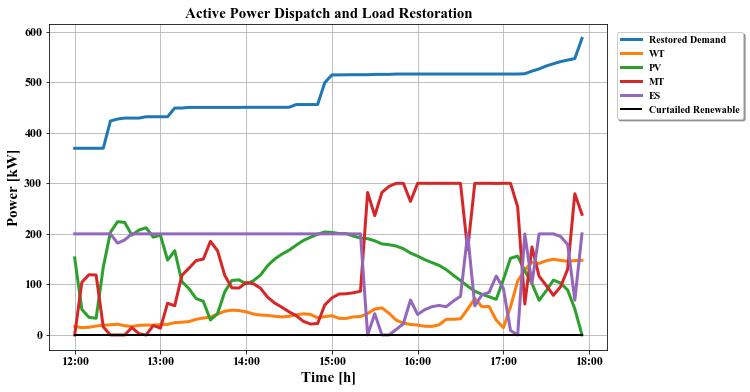

In [19]:
# Result Plots

# Active Power (kW)

plt.figure(figsize=(10,6))
#plt.plot(P_demanded_t, label='Requested Demand', linewidth = 3)
plt.plot(P_restored_t, label='Restored Demand', linewidth = 3)
plt.plot(Pwt_instant, label='WT', linewidth = 3)
plt.plot(Ppv_instant, label='PV', linewidth = 3)
plt.plot(Pmtt, label='MT', linewidth = 3)
plt.plot(Pess, label='ES', linewidth = 3)
plt.plot((Pwt_cutt + Ppv_cutt), label='Curtailed Renewable', linewidth = 2, color = 'black')

plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Power [kW]', fontsize=15)
plt.title('Active Power Dispatch and Load Restoration', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(1.13, 0.99), fancybox=True, shadow=True, ncol=1)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.show()


In [20]:
# Export the total restored load to csv

#Total_restored_load_c75_underforecast = pd.DataFrame(P_restored_t)
#Total_restored_load_c75_underforecast.to_csv('Total_restored_load_c75_underforecast.csv')


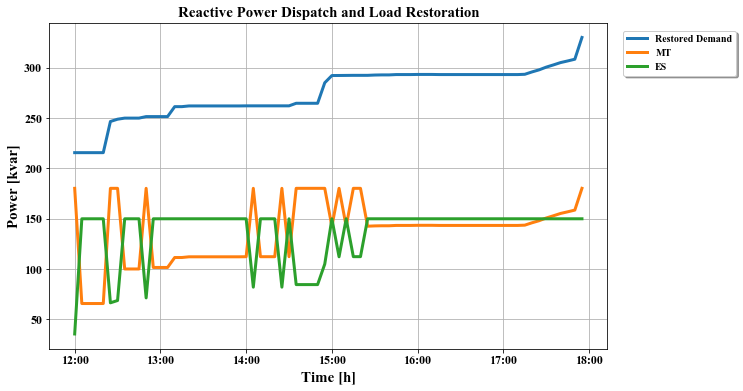

In [21]:
# Result Plots

# Reactive Power (kvar)

plt.figure(figsize=(10,6))
#plt.plot(Q_demanded_t, label='Requested Demand', linewidth = 3)
plt.plot(Q_restored_t, label='Restored Demand', linewidth = 3)
#plt.plot(Qwt_invv, label='WT', linewidth = 3)
#plt.plot(Qpv_invv, label='PV', linewidth = 3)
plt.plot(Qmtt, label='MT', linewidth = 3)
plt.plot(Qess, label='ES', linewidth = 3)

plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Power [kvar]', fontsize=15)
plt.title('Reactive Power Dispatch and Load Restoration', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(1.13, 0.99), fancybox=True, shadow=True, ncol=1)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.show()


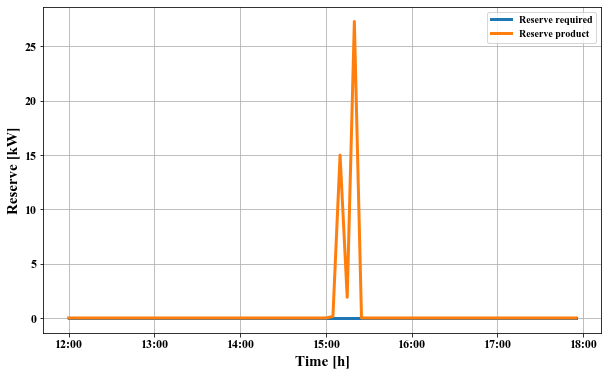

In [22]:
# Reserve plot

plt.figure(figsize=(10,6))
plt.plot(required_reserve,  linewidth = 3, label='Reserve required')
plt.plot(provided_reserve,  linewidth = 3, label='Reserve product')
plt.xlabel('Time [h]', fontsize=15)
#plt.ylim((-10, 1000))
plt.ylabel('Reserve [kW]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
plt.show()


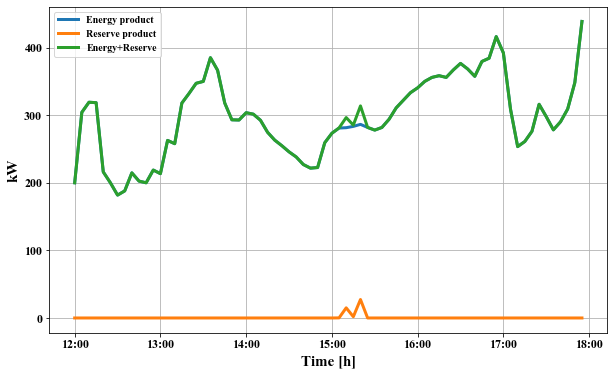

In [23]:
# Energy and reserve plot

plt.figure(figsize=(10,6))
plt.plot(Pmtt+Pess, label='Energy product', linewidth = 3)
plt.plot(provided_reserve,  linewidth = 3, label='Reserve product')
plt.plot(Pmtt+Pess+provided_reserve, linewidth=3, label='Energy+Reserve')
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('kW', fontsize=15)
plt.grid()
plt.legend()
#plt.show()
#plt.savefig('/Users/aeseye/Desktop/energy and reserve products.pdf')


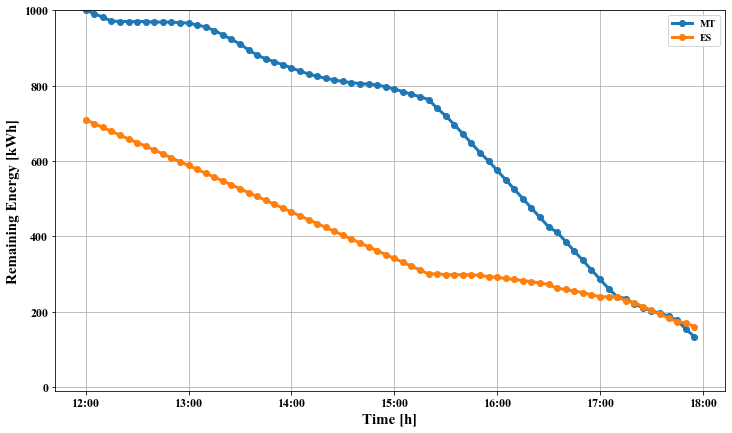

In [24]:
# Remaining Energy of ES and MT

Emt_gen = ([])
Emt_gen = np.append(Emt_gen, 1000 - Pmtt[0]*Δt)
for v in range(1,num_time_steps):
    Emt_gen = np.append(Emt_gen, Emt_gen[v-1] - Pmtt[v]*Δt)

plt.figure(figsize=(12,7))
plt.plot(Emt_gen, label='MT', linewidth = 3, marker='o')
plt.plot(800*SOCes/100, label='ES', linewidth = 3, marker='o')
plt.xlabel('Time [h]', fontsize=15)
plt.ylim((-10, 1000))
plt.ylabel('Remaining Energy [kWh]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
plt.show()


<Figure size 720x432 with 0 Axes>

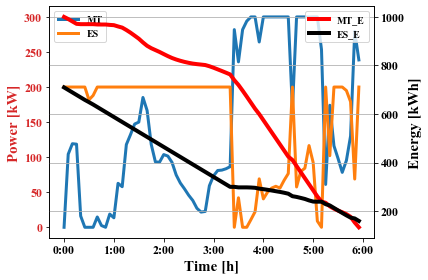

In [25]:
# Power and Remaining Energy of ES and MT

plt.figure(figsize=(10,6))
t = range(num_time_steps)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Power [kW]', color=color)
ax1.plot(t, Pmtt, label='MT', linewidth = 3)
ax1.plot(t, Pess, label='ES', linewidth = 3)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylabel('Power [kW]', fontsize=15)
plt.xlabel('Time [h]', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('Energy [kWh]', color='black')  
ax2.plot(t, Emt_gen, label='MT_E', linewidth = 4, color='red')
ax2.plot(t, 800*SOCes/100, label='ES_E', linewidth = 4, color='black')
ax2.tick_params(axis='y', labelcolor='black')
plt.ylabel('Energy [kWh]', fontsize=15)
fig.tight_layout() 

plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*0, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.show();

#plt.savefig('/Users/aeseye/Desktop/MPC-Dispatching & Restoration.pdf')


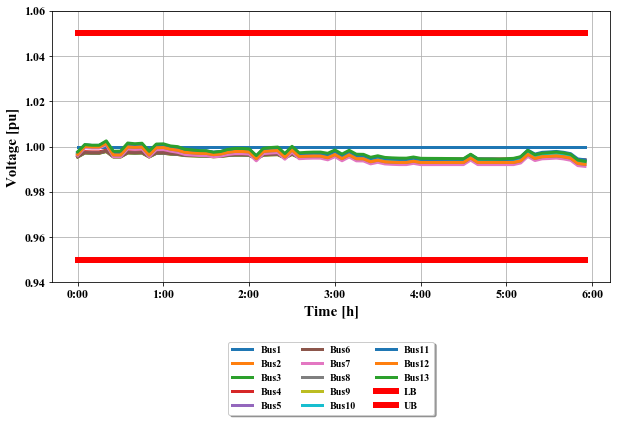

In [26]:
# Voltage Profiles

# ANSI voltage regulation limits (0.95, 1.05)

lower_vol_limit = 0.95
upper_vol_limit = 1.05
lb_volts = ([])
ub_volts = ([])
for j in range(num_time_steps):
    lb_volts = np.append(lb_volts, lower_vol_limit)
    ub_volts = np.append(ub_volts, upper_vol_limit)
    
Buses = ['Bus1','Bus2','Bus3','Bus4','Bus5','Bus6','Bus7','Bus8','Bus9','Bus10','Bus11','Bus12','Bus13']

plt.figure(figsize=(10,5))
for bx in range(len(volts)):
    plt.plot(volts[bx], label = Buses[bx], linewidth = 3)
plt.plot(lb_volts, label = "LB", linewidth = 6, color="red")
plt.plot(ub_volts, label = "UB", linewidth = 6, color="red")
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Voltage [pu]', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*0, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.ylim((0.94, 1.06))
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.show()


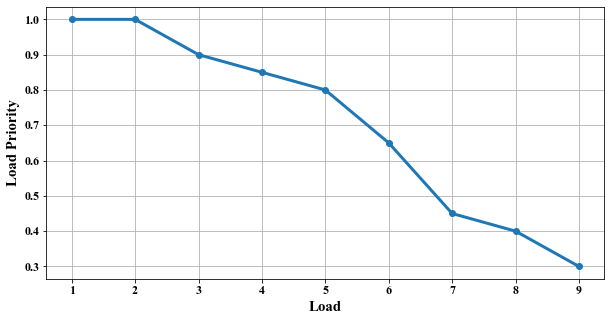

In [27]:
# Plot the Load Priority Weight

load_priority = [1.0, 1.0, 0.9, 0.85, 0.8, 0.65, 0.45, 0.4, 0.3]
#node_idx = range(num_load_buses)
#node_idx = np.array(node_idx)
plt.figure(figsize=(10,5))
plt.plot(load_priority, linewidth = 3, marker="o")
plt.xlabel('Load', fontsize=15)
plt.ylabel('Load Priority', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 9, 1), [str(int(c)) for c in range(1, 10, 1)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()


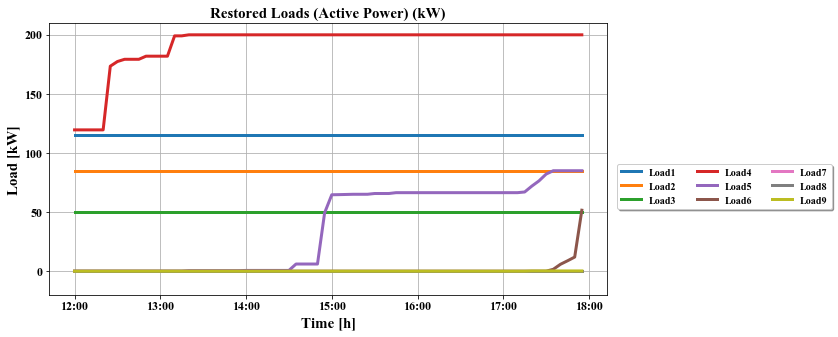

In [28]:
# Plot - restored loads (kW)

Loads = ['Load1','Load2','Load3','Load4','Load5','Load6','Load7','Load8','Load9']

plt.figure(figsize=(10,5))
#for bdx in range(num_buses):
#    plt.plot(P_restoredd[bdx], label = Loads[bdx], linewidth = 3)

plt.plot(P_restoredd[2], label = 'Load1', linewidth = 3)
plt.plot(P_restoredd[3], label = 'Load2', linewidth = 3)
plt.plot(P_restoredd[5], label = 'Load3', linewidth = 3)
plt.plot(P_restoredd[6], label = 'Load4', linewidth = 3)
plt.plot(P_restoredd[7], label = 'Load5', linewidth = 3)
plt.plot(P_restoredd[9], label = 'Load6', linewidth = 3)
plt.plot(P_restoredd[10], label = 'Load7', linewidth = 3)
plt.plot(P_restoredd[11], label = 'Load8', linewidth = 3)
plt.plot(P_restoredd[12], label = 'Load9', linewidth = 3)

plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Load [kW]', fontsize=15)
plt.title('Restored Loads (Active Power) (kW)', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.ylim((-20, 210))
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(1.21, 0.5), fancybox=True, shadow=True, ncol=3)
plt.show()


/Users/aeseye/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


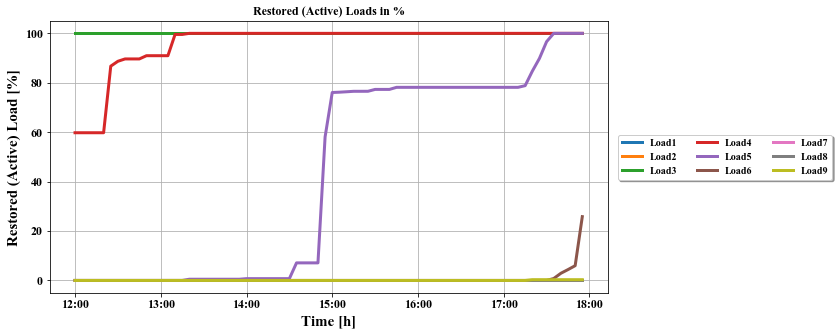

In [29]:
# Plot the percentage of the restored load per time step and node
    # %Restored Load = Restored Load/Actual Load Demand
    
P_restored_t_perc = (P_restoredd / (Pd*Sbase/1000)[:,0:72]) *100

#for dx in range(len(P_restored_t_perc)):
#    plt.plot(P_restored_t_perc[dx], label = Nodes[dx], linewidth = 3)

plt.figure(figsize=(10,5))

plt.plot(P_restored_t_perc[2], label = 'Load1', linewidth = 3)
plt.plot(P_restored_t_perc[3], label = 'Load2', linewidth = 3)
plt.plot(P_restored_t_perc[5], label = 'Load3', linewidth = 3)
plt.plot(P_restored_t_perc[6], label = 'Load4', linewidth = 3)
plt.plot(P_restored_t_perc[7], label = 'Load5', linewidth = 3)
plt.plot(P_restored_t_perc[9], label = 'Load6', linewidth = 3)
plt.plot(P_restored_t_perc[10], label = 'Load7', linewidth = 3)
plt.plot(P_restored_t_perc[11], label = 'Load8', linewidth = 3)
plt.plot(P_restored_t_perc[12], label = 'Load9', linewidth = 3)
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Restored (Active) Load [%]', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.title('Restored (Active) Loads in %')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(1.21, 0.6), fancybox=True, shadow=True, ncol=3)
plt.show()


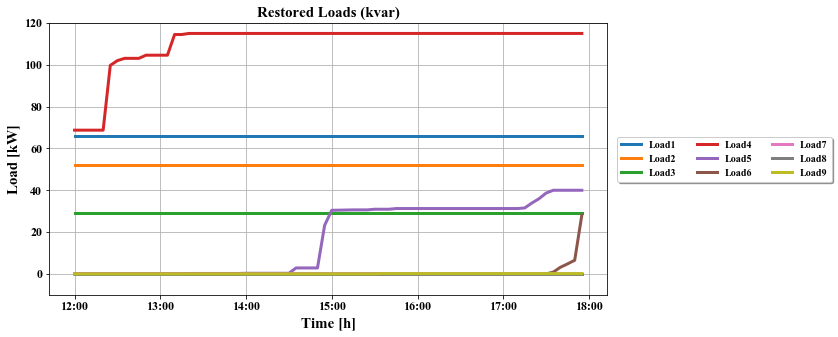

In [30]:
# Plot - restored loads (kvar)

Loads = ['Load1','Load2','Load3','Load4','Load5','Load6','Load7','Load8','Load9']

plt.figure(figsize=(10,5))
#for bdx in range(num_buses):
#    plt.plot(P_restoredd[bdx], label = Loads[bdx], linewidth = 3)

plt.plot(Q_restoredd[2], label = 'Load1', linewidth = 3)
plt.plot(Q_restoredd[3], label = 'Load2', linewidth = 3)
plt.plot(Q_restoredd[5], label = 'Load3', linewidth = 3)
plt.plot(Q_restoredd[6], label = 'Load4', linewidth = 3)
plt.plot(Q_restoredd[7], label = 'Load5', linewidth = 3)
plt.plot(Q_restoredd[9], label = 'Load6', linewidth = 3)
plt.plot(Q_restoredd[10], label = 'Load7', linewidth = 3)
plt.plot(Q_restoredd[11], label = 'Load8', linewidth = 3)
plt.plot(Q_restoredd[12], label = 'Load9', linewidth = 3)

plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Load [kW]', fontsize=15)
plt.title('Restored Loads (kvar)', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.ylim((-10, 120))
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(1.21, 0.6), fancybox=True, shadow=True, ncol=3)
plt.show()


/Users/aeseye/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


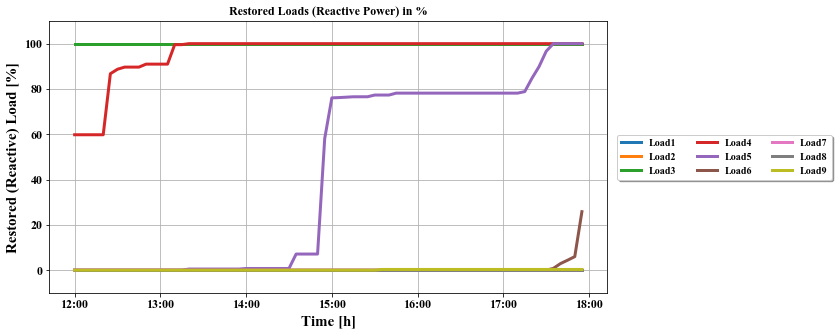

In [31]:
# Plot the percentage of the restored load per time step and node
    # %Restored Load = Restored Load/Actual Load Demand
    
Q_restored_t_perc = (Q_restoredd / (Qd*Sbase/1000)[:,0:72]) *100

#for dx in range(len(P_restored_t_perc)):
#    plt.plot(P_restored_t_perc[dx], label = Nodes[dx], linewidth = 3)

plt.figure(figsize=(10,5))

plt.plot(Q_restored_t_perc[2], label = 'Load1', linewidth = 3)
plt.plot(Q_restored_t_perc[3], label = 'Load2', linewidth = 3)
plt.plot(Q_restored_t_perc[5], label = 'Load3', linewidth = 3)
plt.plot(Q_restored_t_perc[6], label = 'Load4', linewidth = 3)
plt.plot(Q_restored_t_perc[7], label = 'Load5', linewidth = 3)
plt.plot(Q_restored_t_perc[9], label = 'Load6', linewidth = 3)
plt.plot(Q_restored_t_perc[10], label = 'Load7', linewidth = 3)
plt.plot(Q_restored_t_perc[11], label = 'Load8', linewidth = 3)
plt.plot(Q_restored_t_perc[12], label = 'Load9', linewidth = 3)
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Restored (Reactive) Load [%]', fontsize=15)
plt.tick_params(labelsize=12)
plt.ylim((-10, 110))
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.title('Restored Loads (Reactive Power) in %')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(1.21, 0.6), fancybox=True, shadow=True, ncol=3)
plt.show()


In [32]:
# END

In [33]:
# Restored energy

# Restored energy

load_priority = [0.0, 0.0, 1.0, 1.0, 0.0, 0.9, 0.85, 0.8, 0.0, 0.65, 0.45, 0.4, 0.3]

Priorized_total_restored_load = Δt*sum(np.dot(load_priority, P_restoredd))
print("Priorized_total_restored_load: ", Priorized_total_restored_load)


Priorized_total_restored_load:  2623.7958842304915


In [34]:
# Penalty for gradual increase in load shedding

psi = 100

l1 = ([])
for pp in range(1,len(P_restoredd[2])):
    if P_restoredd[2][pp] >= P_restoredd[2][pp-1]:
        dd = 0
        l1 = np.append(l1, dd)
    if P_restoredd[2][pp] < P_restoredd[2][pp-1]:
        dd = P_restoredd[2][pp-1] - P_restoredd[2][pp]
        l1 = np.append(l1, dd)
penalty1 = Δt*psi*load_priority[2]*sum(l1)

l2 = ([])
for pp in range(1,len(P_restoredd[3])):
    if P_restoredd[3][pp] >= P_restoredd[3][pp-1]:
        dd = 0
        l2 = np.append(l2, dd)
    if P_restoredd[3][pp] < P_restoredd[3][pp-1]:
        dd = P_restoredd[3][pp-1] - P_restoredd[3][pp]
        l2 = np.append(l2, dd)
penalty2 = Δt*psi*load_priority[3]*sum(l2)

l3 = ([])
for pp in range(1,len(P_restoredd[5])):
    if P_restoredd[5][pp] >= P_restoredd[5][pp-1]:
        dd = 0
        l3 = np.append(l3, dd)
    if P_restoredd[5][pp] < P_restoredd[5][pp-1]:
        dd = P_restoredd[5][pp-1] - P_restoredd[5][pp]
        l3 = np.append(l3, dd)
penalty3 = Δt*psi*load_priority[5]*sum(l3)

l4 = ([])
for pp in range(1,len(P_restoredd[6])):
    if P_restoredd[6][pp] >= P_restoredd[6][pp-1]:
        dd = 0
        l4 = np.append(l4, dd)
    if P_restoredd[6][pp] < P_restoredd[6][pp-1]:
        dd = P_restoredd[6][pp-1] - P_restoredd[6][pp]
        l4 = np.append(l4, dd)
penalty4 = Δt*psi*load_priority[6]*sum(l4)

l5 = ([])
for pp in range(1,len(P_restoredd[7])):
    if P_restoredd[7][pp] >= P_restoredd[7][pp-1]:
        dd = 0
        l5 = np.append(l5, dd)
    if P_restoredd[7][pp] < P_restoredd[7][pp-1]:
        dd = P_restoredd[7][pp-1] - P_restoredd[7][pp]
        l5 = np.append(l5, dd)
penalty5 = Δt*psi*load_priority[7]*sum(l5)

l6 = ([])
for pp in range(1,len(P_restoredd[9])):
    if P_restoredd[9][pp] >= P_restoredd[9][pp-1]:
        dd = 0
        l6 = np.append(l6, dd)
    if P_restoredd[9][pp] < P_restoredd[9][pp-1]:
        dd = P_restoredd[9][pp-1] - P_restoredd[9][pp]
        l6 = np.append(l6, dd)
penalty6 = Δt*psi*load_priority[9]*sum(l6)

l7 = ([])
for pp in range(1,len(P_restoredd[10])):
    if P_restoredd[10][pp] >= P_restoredd[10][pp-1]:
        dd = 0
        l7 = np.append(l7, dd)
    if P_restoredd[10][pp] < P_restoredd[10][pp-1]:
        dd = P_restoredd[10][pp-1] - P_restoredd[10][pp]
        l7 = np.append(l7, dd)
penalty7 = Δt*psi*load_priority[10]*sum(l7)

l8 = ([])
for pp in range(1,len(P_restoredd[11])):
    if P_restoredd[11][pp] >= P_restoredd[11][pp-1]:
        dd = 0
        l8 = np.append(l8, dd)
    if P_restoredd[11][pp] < P_restoredd[11][pp-1]:
        dd = P_restoredd[11][pp-1] - P_restoredd[11][pp]
        l8 = np.append(l8, dd)
penalty8 = Δt*psi*load_priority[11]*sum(l8)

l9 = ([])
for pp in range(1,len(P_restoredd[12])):
    if P_restoredd[12][pp] >= P_restoredd[12][pp-1]:
        dd = 0
        l9 = np.append(l9, dd)
    if P_restoredd[12][pp] < P_restoredd[12][pp-1]:
        dd = P_restoredd[12][pp-1] - P_restoredd[12][pp]
        l9 = np.append(l9, dd)
penalty9 = Δt*psi*load_priority[12]*sum(l9)

LoadSheddingInceasePenalties = [penalty1, penalty2, penalty3, penalty4, penalty5, penalty6, 
                                penalty7, penalty8, penalty9]

# Total Penalty

LoadSheddingInceasePenalty = sum(LoadSheddingInceasePenalties)

print("LoadSheddingInceasePenalty: ", LoadSheddingInceasePenalty)


LoadSheddingInceasePenalty:  1.0846582891114544e-11


In [35]:
# Penalty for renewable power curtailment

alpha = 0.2  #$/kWh
Penalized_total_wind_curtailment = alpha*sum(Pwt_cutt)*Δt
print("Wind Curtailment Penalty", Penalized_total_wind_curtailment)

beta = 0.2  #$/kWh
Penalized_total_pv_curtailment = beta*sum(Ppv_cutt[1:num_time_steps])*Δt
print("PV Curtailment Penalty", Penalized_total_pv_curtailment)

Penalized_RE_curtailment = Penalized_total_wind_curtailment + Penalized_total_pv_curtailment

print("RE Curtailment Penalty", Penalized_RE_curtailment)


Wind Curtailment Penalty 0.0
PV Curtailment Penalty 0.0
RE Curtailment Penalty 0.0


In [36]:
# Objective Function Value

Objective_fn_value = Priorized_total_restored_load - LoadSheddingInceasePenalty - Penalized_RE_curtailment
print("Objective Function Value: ", Objective_fn_value)


Objective Function Value:  2623.7958842304806


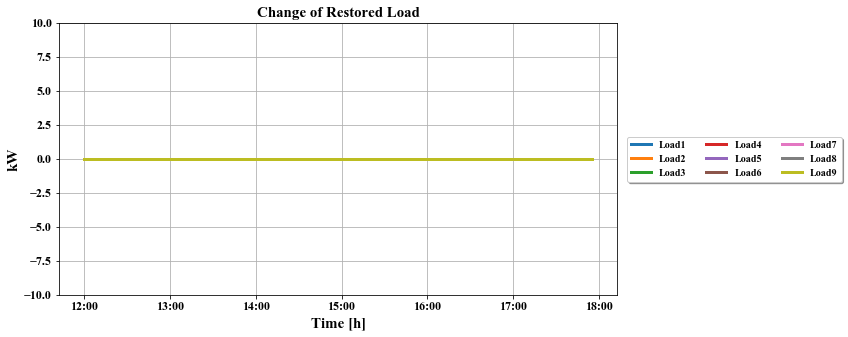

In [37]:
# Plot the change of restored load over time

plt.figure(figsize=(10,5))

plt.plot(mu_PP[2], label = 'Load1', linewidth = 3)
plt.plot(mu_PP[3], label = 'Load2', linewidth = 3)
plt.plot(mu_PP[5], label = 'Load3', linewidth = 3)
plt.plot(mu_PP[6], label = 'Load4', linewidth = 3)
plt.plot(mu_PP[7], label = 'Load5', linewidth = 3)
plt.plot(mu_PP[9], label = 'Load6', linewidth = 3)
plt.plot(mu_PP[10], label = 'Load7', linewidth = 3)
plt.plot(mu_PP[11], label = 'Load8', linewidth = 3)
plt.plot(mu_PP[12], label = 'Load9', linewidth = 3)
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('kW', fontsize=15)
plt.tick_params(labelsize=12)
plt.ylim((-10, 10))
plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.title('Change of Restored Load', fontsize=15)
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(1.21, 0.6), fancybox=True, shadow=True, ncol=3)
plt.show()
